<a href="https://colab.research.google.com/github/Claussss/GSoC_evaluation_tests/blob/main/Specific_Test_II_Learning_the_DM_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Specific Test II. Learning the DM representation 

## Unsupervised Anomaly Detection and Transfer Learning

For this task I decided to use the properties of Autoencoder to solve the anomaly detection problem. This method is based on the following paper:

**[Anomaly Detection with Adversarial Dual Autoencoders](https://arxiv.org/ftp/arxiv/papers/1902/1902.06924.pdf)**

I loaded the provided Adversarial Encoder model and finetuned (trained only on no_sub images).

To classify whether an image is an anomaly, I run the trained Autoencoder and calculate MSE loss between the reconstructed image and the original one. If the loss is higher than the threshold, which is chosen after observing the distribution of the test set, the image is classified as an anomaly.

While training on no_sub images, the model generates a normal distribution for no_sum images, and when we try to reconstruct sub images, it will be out of the distribution; consequently, the reconstruction loss will be high.

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
import torch
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cloning DeepLens Repo

In [ ]:
%%capture
!git clone https://github.com/ML4SCI/ML4SCI_GSoC.git

In [ ]:
%%capture
# Unzip all the lens images into root directory
!tar -xvf '/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/lenses.tgz'

### Adversarial Autoencoder Model Architecture

In [ ]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.linear = nn.Linear(5184, 1000)

    def forward(self, x):

        convolution1 = F.relu(self.conv1(x))
        convolution2 = F.relu(self.conv2(convolution1))
        convolution3 = F.relu(self.conv3(convolution2))
        Flattened = self.flat(convolution3)
        z = self.linear(Flattened)

        return z

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(1000, 5184)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1, output_padding=2)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=2)

    def forward(self, x):

        hidden = self.linear(x)
        Reshaped = hidden.reshape(-1,64,9,9)
        convolution4 = F.relu(self.conv4(Reshaped))
        convolution5 = F.relu(self.conv5(convolution4))
        predicted = torch.tanh(self.conv6(convolution5))

        return predicted

class Discriminator(nn.Module):

    def __init__(self, dim_z=1000 , dim_h=256):
        super(Discriminator,self).__init__()
        self.dim_z = dim_z
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Linear(self.dim_h,1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)
        return disc

In [ ]:
class AdversialAutoencoder():
  """
  The class represents an Adversial Autoencoder for anomaly detection.
  """
  

  def __init__(self):
    self.cuda = torch.cuda.is_available()

    if self.cuda:
      # Initialize the model
      self.encoder = Encoder().cuda()
      self.decoder = Decoder().cuda()
      self.discriminator = Discriminator().cuda()
    else:
      self.encoder = Encoder()
      self.decoder = Decoder()
      self.discriminator = Discriminator()

    # Lists of epoch erorrs
    self.recon_loss_list = []
    self.discriminator_loss_list = []
    self.generator_loss_list = []

  def get_losses(self):
    """
    Returns a dictionary with loss name and its values
    """
    return {
        'Reconstruction Loss': self.recon_loss_list,
        'Discriminator Loss' : self.discriminator_loss_list,
        'Generator Loss' : self.generator_loss_list
    }
  
  def save_model(self,path_dict):
    """
    Saves encoder,decoder, and discriminator to the pathes specified in path_dict.
    path_dict = {
      'encoder': path_to_encoder_file,
      'decoder': path_to_decoder_file,
      'discriminator': path_to_discriminator_file}
    """
    torch.save(self.encoder,path_dict['encoder'])
    torch.save(self.decoder,path_dict['decoder'])
    torch.save(self.discriminator,path_dict['discriminator'])
        

  def load_model(self,path_dict):
    """
    Loads encoder,decoder,and discriminator from the files specified in path_dict.
      path_dict = {
      'encoder': path_to_encoder_file,
      'decoder': path_to_decoder_file,
      'discriminator': path_to_discriminator_file}
    """
    self.encoder = torch.load(path_dict['encoder'])
    self.decoder = torch.load(path_dict['decoder'])
    self.discriminator = torch.load(path_dict['discriminator'])

  def calculate_discriminator_loss(self,D_real_gauss,D_fake_gauss, TINY):
    """
       Calculates discriminator loss.
       D_real_gauss - a value from normal disribution.
       D_fake_gauss - a value from a distribution that tries to imitate normal.
       TINY - a small value that prevents the loss from reaching 0.
    """
    return -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))

  def calculate_generator_loss(self,D_fake_gauss, TINY):
    """
       Calculates generator loss.
       D_fake_gauss - a value from a distribution that tries to imitate normal.
       TINY - a small value that prevents the loss from reaching 0.
    """
    return -torch.mean(torch.log(D_fake_gauss + TINY))

  def calculate_reconstruction_loss(self,reconstructed_X,X):
    """
    Calculates reconstruction loss.
    Reconstructed_X - X which were encoded and decoded back.
    X  - initial X value.
    """
    mse = nn.MSELoss()
    return mse(reconstructed_X,X)

  def reconstruct(self, x):
    """
    Converts an image into the latent space and reconstructs it back.
    """

    if self.cuda:
      X = x.data.cuda()

    encoded_x = self.encode(X)
    reconstructed_x = self.decode(encoded_x)
    return reconstructed_x

  def encode(self,x):
    """
    Converts an image into the learnt latent space.
    """
    self.encoder.eval()

    if self.cuda:
      X = x.data.cuda()
    return self.encoder(X)

  def decode(self,x):
    """
    Decodes an image from the learnt latent space.
    """
    self.decoder.eval()
    
    if self.cuda:
      X = x.data.cuda()
    return self.decoder(X)


  def train(self,train_loader,verbose,**kwargs):
    """
    Trains the model.
    If verbose is True, prints stats for every epoch.
    """

    # Initialize optimizators
    self.decoder_optim = torch.optim.Adam(self.decoder.parameters(), lr=reg_lr,)
    self.encoder_optim = torch.optim.Adam(self.encoder.parameters(), lr=reg_lr)
    self.discriminator_optim  = torch.optim.Adam(self.discriminator.parameters(), lr=reg_lr)
    self.generator_optim = torch.optim.Adam(self.encoder.parameters(), lr=gen_lr)


    
    for epoch in range(epochs):
      # Initialize running losses
      running_recon_loss = 0
      running_discriminator_loss = 0
      running_generator_loss = 0

      for X,_ in train_loader:
          if self.cuda:
            X = X.data.cuda()
          # Zero the gradients
          self.decoder_optim.zero_grad() 
          self.encoder_optim.zero_grad()
          self.generator_optim.zero_grad()
          self.discriminator_optim.zero_grad()

          self.decoder_scheduler = ReduceLROnPlateau(self.decoder_optim, 'min',patience=5)
          self.encoder_scheduler = ReduceLROnPlateau(self.encoder_optim, 'min',patience=5)
          self.generator_scheduler = ReduceLROnPlateau(self.generator_optim, 'min',patience=5)
          self.discriminator_scheduler = ReduceLROnPlateau(self.discriminator_optim, 'max',patience=5)

          
          # Turn on the train mode
          self.encoder.train()
          self.decoder.train()
          self.discriminator.train()

          # Reconstruction phase
          z_sample = self.encoder(X)
          X_sample = self.decoder(z_sample)
          recon_loss = self.calculate_reconstruction_loss(X_sample,X)
          running_recon_loss += recon_loss

          recon_loss.backward()
          self.decoder_optim.step()
          self.encoder_optim.step()

          # Regularization phase
          self.encoder.eval() 
          # Generating a value from Gaussian distribution with mean 0 and variance 1 
          z_real_gauss = torch.autograd.Variable(torch.randn(train_loader.batch_size, 1000))
          z_real_gauss = z_real_gauss.cuda() if self.cuda else z_real_gauss
          z_fake_gauss = self.encoder(X)

          # Compute discriminator outputs and loss
          D_real_gauss, D_fake_gauss = self.discriminator(z_real_gauss), self.discriminator(z_fake_gauss)
          D_loss_gauss = self.calculate_discriminator_loss(D_real_gauss, D_fake_gauss,TINY)
          running_discriminator_loss += D_loss_gauss

          D_loss_gauss.backward()    
          self.discriminator_optim.step() 
         

          # Generator
          self.encoder.train()
          z_fake_gauss = self.encoder(X)
          D_fake_gauss = self.discriminator(z_fake_gauss)

          G_loss = self.calculate_generator_loss(D_fake_gauss,TINY)
          running_generator_loss += G_loss

          G_loss.backward()
          self.generator_optim.step()
         
      # Updating the shedulers
      self.encoder_scheduler.step(running_recon_loss)
      self.decoder_scheduler.step(running_recon_loss)
      self.discriminator_scheduler.step(running_discriminator_loss)
      self.generator_scheduler.step(running_generator_loss)


      epoch_recon_loss =  running_recon_loss/len(train_loader.dataset)
      epoch_discriminator_loss =  running_discriminator_loss/len(train_loader.dataset)
      epoch_generator_loss =  running_generator_loss/len(train_loader.dataset)

      self.recon_loss_list.append(epoch_recon_loss)
      self.discriminator_loss_list.append(epoch_discriminator_loss)
      self.generator_loss_list.append(epoch_generator_loss)

      if verbose:
        print(f"====== Epoch {epoch+1} ======")
        print(f'Reconstruction loss: {epoch_recon_loss}')
        print(f'Discriminator loss: {epoch_discriminator_loss}')
        print(f'Generator loss: {epoch_generator_loss}')
        print("==============================")


### Generating Datasets

In [ ]:
# Image size has to correspond to the first layer of the encoder
trsf = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize((150, 150)),
                           transforms.Grayscale(num_output_channels=1)])

In [ ]:
lens_dataset = torchvision.datasets.ImageFolder(root='lenses',transform=trsf)
lens_dataset.class_to_idx

{'no_sub': 0, 'sub': 1}

No_sub images are the norm.

Sub images are regarded as anomalies.

#### Splitting the dataset into training and testing

In [ ]:
# 20% of the data will be used for testing
test_split = 0.2
num_of_images = len(lens_dataset)
n_train = int(num_of_images*(1-test_split))
n_test = int(num_of_images*test_split)
print(f'Number of images in train dataset: {n_train}')
print(f'Number of images in test dataset: {n_test}')

Number of images in train dataset: 8000
Number of images in test dataset: 2000


In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(lens_dataset,[n_train,n_test])

In [ ]:
no_sub_counter = 0
sub_counter = 0
for _,label in test_dataset:
  if label==0:
    no_sub_counter+=1
  else:
    sub_counter+=1
print("Class Distribution in the test dataset")
print(f"Number of No_Sub images: {no_sub_counter} (class 0)")
print(f"Number of Sub images: {sub_counter} (class 1)")

Class Distribution in the test dataset
Number of No_Sub images: 1012 (class 0)
Number of Sub images: 988 (class 1)


Currently both train_dataset and test_dataset contain 2 classes (sub and no_sub).

For test we need both classes to evaluate the performance of the model, but we need only no_sub images for training.

In [ ]:
# Removing sub class from training dataset
indx_of_indx_list = []
for i,(image,label) in enumerate(train_dataset):
  if(label==0):
    indx_of_indx_list.append(i)

no_sub_train_indx = np.array(train_dataset.indices)[indx_of_indx_list]
train_dataset_no_sub = torch.utils.data.Subset(lens_dataset,no_sub_train_indx)

In [ ]:
def get_data_loader(dataset,shuffle,batch_size):
  """
  Returns a pytorch dataloader created from the provided parameters.
  """
  loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last = True
        )
  return loader

### Initialazing and training the model

In [ ]:
advers_encoder = AdversialAutoencoder()

The hyperparameters were chosen manually.

In [ ]:
# Learning rates
reg_lr,gen_lr = 1e-4, 1e-5
epochs = 60
# Small number that prohibits the discriminator and generator loss from being 0
TINY = 1e-12

#### Load trained weights

In [ ]:
weights_path_dict = {
    'encoder':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Encoder.pth',
    'decoder':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Decoder.pth',
    'discriminator':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/AAE_Discriminator.pth'
}

In [ ]:
%%capture
advers_encoder.load_model(weights_path_dict)

#### Train the model

In [ ]:
advers_encoder.train(train_loader=get_data_loader(train_dataset_no_sub,True,32),verbose=True,
                     gen_lr=gen_lr,reg_lr=reg_lr,
                     epochs=epochs,TINY=TINY)

====== Epoch 1 ======
Reconstruction loss: 3.220149301341735e-05
Discriminator loss: 0.0013721988070756197
Generator loss: 0.7568175196647644
====== Epoch 2 ======
Reconstruction loss: 4.888579042017227e-06
Discriminator loss: 0.0015260122017934918
Generator loss: 0.6351361274719238
====== Epoch 3 ======
Reconstruction loss: 2.4097755613183836e-06
Discriminator loss: 0.0021369573660194874
Generator loss: 0.6768459677696228
====== Epoch 4 ======
Reconstruction loss: 1.7332105244349805e-06
Discriminator loss: 0.0031342615839093924
Generator loss: 0.7082040905952454
====== Epoch 5 ======
Reconstruction loss: 1.436098159501853e-06
Discriminator loss: 0.002156702568754554
Generator loss: 0.7003207802772522
====== Epoch 6 ======
Reconstruction loss: 1.2600251011463115e-06
Discriminator loss: 0.0020070557948201895
Generator loss: 0.653377115726471
====== Epoch 7 ======
Reconstruction loss: 1.1574001064218464e-06
Discriminator loss: 0.0012676742626354098
Generator loss: 0.5973259806632996
====

#### Save finetuned weights

In [ ]:
save_weights_path_dict = {
    'encoder':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/finetuned_AAE_Encoder.pth',
    'decoder':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/finetuned_AAE_Decoder.pth',
    'discriminator':'/content/ML4SCI_GSoC/DeepLense/Domain Adaptation/Model_Weights/finetuned_AAE_Discriminator.pth'
}

In [ ]:
advers_encoder.save_model(save_weights_path_dict)

### Plot losses

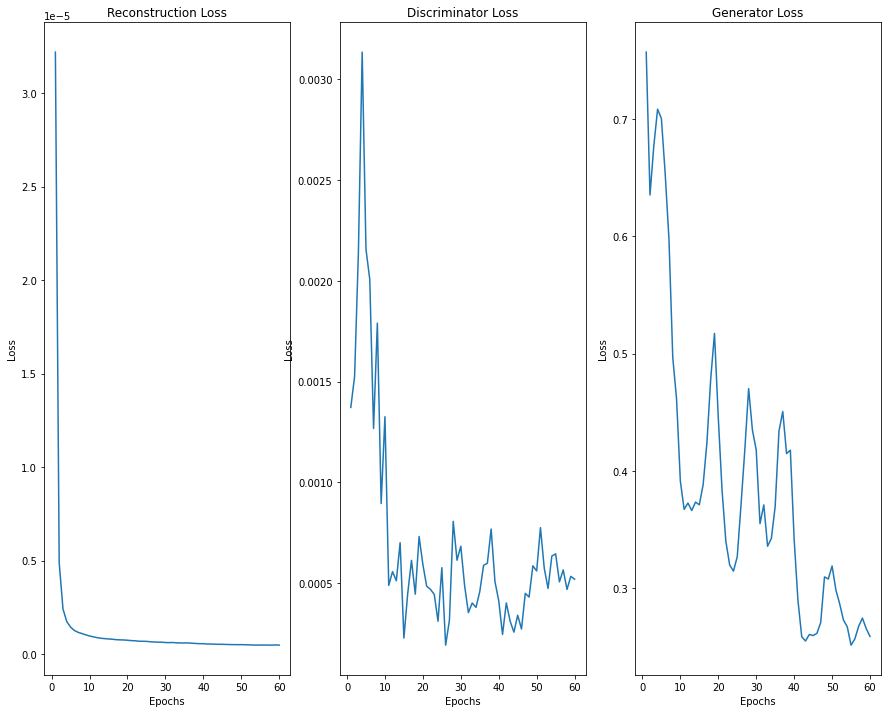

In [ ]:
_, ax = plt.subplots(1,3,figsize=(15,12))
num_of_epochs = len(advers_encoder.recon_loss_list)
epochs_list = range(1,num_of_epochs+1)
losses_dict = advers_encoder.get_losses()

for i,(loss_title, loss_list) in enumerate(losses_dict.items()):
  ax[i].set_title(loss_title)
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Loss')
  ax[i].plot(epochs_list,loss_list)

plt.show()

Reconstruction loss has descreased, which is good. And Discriminator loss is insreasing, which shows that discriminator has difficutly differentiating real and fake images.

### Finding Reconstruction Threshold

To find a reconstruction threshold, I run trained Autoencoder on the test dataset and save all the reconstruction losses.

After that I plot the losses and choose an appropriate threshold basing on the graph.

In [ ]:
loss_dist = []
# We predict loss for every element, so batch_size has to equal 1
for X,_ in get_data_loader(test_dataset,False,1):
  if advers_encoder.cuda:
    X = X.cuda()
  X_sample = advers_encoder.reconstruct(X)
  recon_loss = advers_encoder.calculate_reconstruction_loss(X_sample,X)

  loss_dist.append(recon_loss.item())

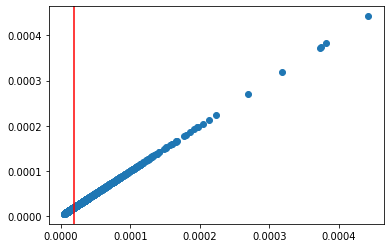

In [ ]:
reconstruction_threshold = np.median(loss_dist)

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.axvline(x=upper_threshold,c='r')
plt.scatter(*zip(*loss_sc))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


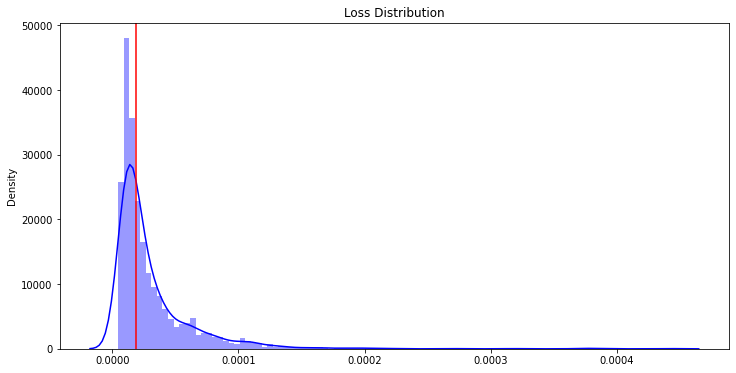

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(reconstruction_threshold, 0.0, 10, color='r')

Basing on the plot, the model has difficulty separating the classes.

To fix that I might use KDE threshold. (I will disscuss the method the Possible Improvments section). 


So far I came up with an heuristic. I use median of all the reconstruction losses from the test dataset as the threshold since discriminator forces encoder to generate normal distribution.

### Predicting anomalies (Testing the model)

In [ ]:
labels = []
pred_label = []

for X,label in get_data_loader(test_dataset,False,1):
  if advers_encoder.cuda:
    X = X.cuda()
  z_sample = advers_encoder.encode(X)
  X_sample = advers_encoder.decode(z_sample)
  recon_loss = advers_encoder.calculate_reconstruction_loss(X_sample,X)

  labels.append(label)
  pred_label.append(int(recon_loss  >= reconstruction_threshold))

#### Confusion matrix

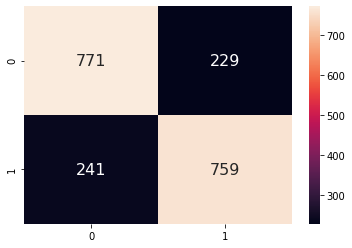

In [ ]:
tn,fp,fn,tp = confusion_matrix(pred_label ,labels).ravel()

conf = [[tn,fp],[fn,tp]]
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

#### ROC cuve and AUC score

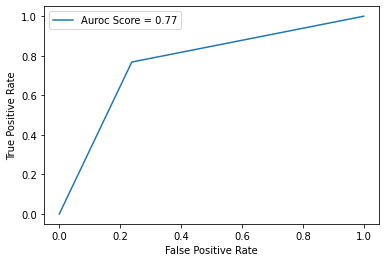

In [ ]:
fpr, tpr, thresholds = roc_curve(labels, pred_label)
auroc_score = auc(fpr, tpr)

title = f'Auroc Score = {round(auroc_score,2)}'
plt.plot(fpr, tpr, label=title )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Possible Improvements

1) **[Robust Anomaly Detection in Images using Adversarial Autoencoders](https://arxiv.org/pdf/1901.06355.pdf)** paper proposes Kernel density estimation as a metric of anomalousness.

Instead of relying on the reconstruction error they also consider the likehood of an image in latent space.

Basically, it regards images that are far away from other images as anomalous.

My implementation of the method didn't work, but in general it might be a good idea.


2) Another thing that could be improved is the **train function in AdversialAutoencoder** class. Now I am performing all the phases in sequence (reconstruction, regularization, etc). It might help if I do reconstruction phase for a few epochs, and when it is good enough, start another phase (regularization).
